# Exprimenting and Modeling

In [17]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
import xgboost as xgb



## Loading data and splitting it 

In [27]:
norm_data = pd.read_csv('../data/processed/expriment_df.csv',delimiter=',')
norm_data.set_index('CUSTOMER_ID', inplace=True)
norm_data.head()

,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,LESSTHAN600k,CHILD,JOB_CLASS,REVENUE,...,REPORTED_SATISFACTION_unsat,REPORTED_SATISFACTION_very_sat,REPORTED_SATISFACTION_very_unsat,REPORTED_USAGE_LEVEL_avg,REPORTED_USAGE_LEVEL_high,REPORTED_USAGE_LEVEL_little,REPORTED_USAGE_LEVEL_very_high,REPORTED_USAGE_LEVEL_very_little,CHURNED_LEAVE,CHURNED_STAY
CUSTOMER_ID,,,,,,,,,,,,,,,,,,,,,
C100000,0,0.342068,-1.235851,-0.947823,-0.892885,1.521888,0,4,3,0.094061,...,0,0,1,0,0,1,0,0,0,1
C100001,1,-0.405661,-0.720966,0.883351,-0.331492,-0.440526,1,0,1,-1.159304,...,1,0,0,0,0,1,0,0,1,0
C100006,0,-0.643620,0.860414,-0.947823,-0.406344,1.677104,0,4,2,-0.595290,...,0,0,0,0,0,0,0,1,0,1
C100008,0,-0.520608,-0.300027,1.214144,-0.892885,1.868824,0,3,3,-1.451756,...,1,0,0,0,0,0,1,0,1,0
C100010,1,-0.138431,-0.189826,1.414983,-0.892885,-0.435752,1,2,3,-1.639761,...,0,0,1,0,0,1,0,0,1,0


for split we picking only the relevent columns 

In [24]:
relevant_columns = [
    'HOUSE',
    'OVERCHARGE',
    'DATA',
    'INCOME',
    'OVER_15MINS_CALLS_PER_MONTH',
    'REPORTED_SATISFACTION_very_sat',
    'LEFTOVER',
    'HANDSET_PRICE',
    'AVERAGE_CALL_DURATION',
    'TIME_CLIENT',
    'REPORTED_SATISFACTION_very_unsat'
]

# Assuming `df` is your dataframe and `target` is the name of the target column
X = norm_data[relevant_columns]
y = norm_data['CHURNED_STAY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train

In [25]:
xgb_clf = xgb.XGBClassifier()
xgb_clf = xgb_clf.fit(X_train, y_train)

## Eval

ROC AUC: 0.8400982963304038


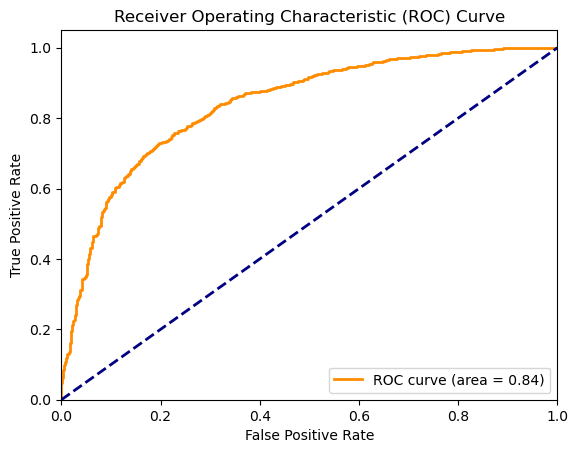

In [26]:
# Predict probabilities
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Compute ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc}")

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Output pd Result

In [40]:
customer_ids = X_test.index

# Predict probabilities and labels
churn_probabilities = xgb_clf.predict_proba(X_test)[:, 1]
churn_labels = xgb_clf.predict(X_test)
churn_labels = ['LEAVE' if label == 0 else 'STAY' for label in churn_labels]
real_churn_labels = ['LEAVE' if label == 0 else 'STAY' for label in y_test]

In [44]:
# Determine CLIENT_TO_CONTACT based on churn probability threshold (e.g., 0.5)
client_to_contact = ['YES' if prob > 0.5 else 'NO' for prob in churn_probabilities]

# Propose DISCOUNT based on churn probability
def propose_discount(probability):
    if probability > 0.75:
        return '20%'
    elif probability > 0.5:
        return '15%'
    elif probability > 0.25:
        return '10%'
    else:
        return '5%'

discounts = [propose_discount(prob) for prob in churn_probabilities]
# Create the DataFrame
results_df = pd.DataFrame({
    'CUSTOMER_ID': customer_ids,
    'THE GROUND TRUTH CHRUNED':real_churn_labels, 
    'THE PRED CHURNED': churn_labels,
    'CHURN_PROBABILITY': churn_probabilities,
    'CLIENT_TO_CONTACT': client_to_contact,
    'DISCOUNT': discounts
})

In [45]:
# Display the DataFrame
results_df

,CUSTOMER_ID,THE GROUND TRUTH CHRUNED,THE PRED CHURNED,CHURN_PROBABILITY,CLIENT_TO_CONTACT,DISCOUNT
0,C106601,STAY,STAY,0.974436,YES,20%
1,C100760,STAY,STAY,0.799224,YES,20%
2,C109872,STAY,STAY,0.918493,YES,20%
3,C110408,STAY,STAY,0.970744,YES,20%
4,C113945,LEAVE,STAY,0.807691,YES,20%
...,...,...,...,...,...,...
2265,C108915,STAY,STAY,0.951487,YES,20%
2266,C103480,LEAVE,LEAVE,0.060307,NO,5%
2267,C101038,STAY,STAY,0.736183,YES,15%
2268,C112906,STAY,STAY,0.560056,YES,15%


## No Labled data testing

In [46]:
val_data = pd.read_csv('../data/raw/validation.csv',delimiter=',')
val_data.set_index('CUSTOMER_ID', inplace=True)
val_data.head()

,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,LESSTHAN600k,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN
CUSTOMER_ID,,,,,,,,,,,,,,,,,
C100002,one,80.000000,45452.5,75,65,342741.0,True,3,1,149.0,300,3,2.2,2,unsat,little,considering
C100003,zero,536.842105,40703.5,90,0,215904.0,True,1,1,176.0,384,4,2.4,13,unsat,very_high,actively_looking_into_it
C100004,zero,256.578947,35563.0,52,0,341828.0,True,2,3,124.0,371,5,2.3,12,very_sat,avg,considering
C100005,zero,466.666667,66072.5,0,8,257222.0,True,3,1,279.0,324,1,2.8,5,very_sat,very_little,actively_looking_into_it
C100007,zero,150.000000,21901.5,0,0,800811.0,False,1,3,128.0,164,1,1.5,12,avg,very_high,perhaps
